<a href="https://colab.research.google.com/github/KimJunGu9/DeepLearning_Pytorch/blob/main/1_1_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 라이브러리 호출

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

### CPU 또는 GPU 장치 확인

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 다수의 CPU를 사용한다면 nn.DataParalell를 사용

### fashion_mnist 데이터셋 내려받기

In [4]:
train_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/DL_pytorch/chap05/data', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/DL_pytorch/chap05/data', download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()]))

# transform : 이미지를 텐서(0~1)로 변경

### fashion_mnist 데이터를 데이터로더에 전달

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

# torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러옴
# train_dataset : 첫번째 파라미터, 데이터를 불러올 데이터셋을 지정

### 분류에 사용될 클래스 정의

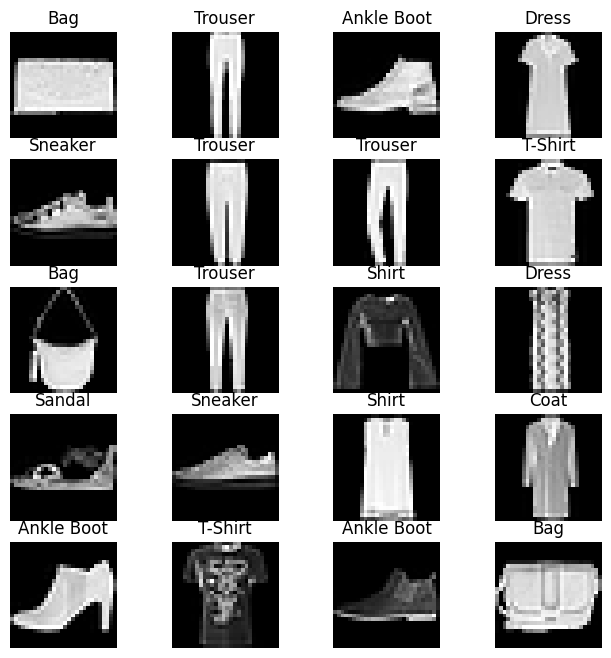

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}


fig = plt.figure(figsize = (8, 8))
columns = 4;
rows = 5;


for i in range(1, columns * rows + 1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0, :, :]  # train_dataset을 이용한 3차원 배열을 생성
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

plt.show()

# np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출

### 심층 신경망 모델 생성

In [7]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features = 784, out_features = 256) # 입력 크기 : 784, 출력크기 : 256
    self.drop = nn.Dropout(0.25) # 과대적합되지않게 0.25를 버리고 0.75를 학습
    self.fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, input_data):  # 순전파
    out = input_data.view(-1, 784)  # (-1,784)는 (?, 784)의 크기로 변경하라는 의미.
                                    # 첫번재 차원(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미
                                    # (2차원텐서로 변경하되 (?, 784)의 크기로 변경하라)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

### 심층 신경망에서 필요한 파라미터 정의

In [8]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);
# 옵티마이저를 위한 경사하강법은 Adam을 사용

print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### 심층 신경망을 이용한 모델 학습

In [9]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []


for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))  # Variable을 사용하여 역전파를 위한 미분 값을 자동으로 계산함
    labels = Variable(labels)

    outputs = model(train)  # 학습데이터를 모델에 적용
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count += 1

    if not (count % 50): # count를 50으로 나누었을때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total  # 분류문제에 대한 정확도
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%". format(count, loss.data, accuracy))

Iteration : 500, Loss : 0.6062203645706177, Accuracy : 83.33999633789062%
Iteration : 1000, Loss : 0.47227761149406433, Accuracy : 84.50999450683594%
Iteration : 1500, Loss : 0.3651779294013977, Accuracy : 84.93999481201172%
Iteration : 2000, Loss : 0.39236128330230713, Accuracy : 85.50999450683594%
Iteration : 2500, Loss : 0.2304176539182663, Accuracy : 86.1199951171875%
Iteration : 3000, Loss : 0.3631836175918579, Accuracy : 85.98999786376953%


### 합성곱 네트워크 생성

In [10]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(  # 합성곱층
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(  # 합성곱층
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features = 64 * 6 * 6, out_features = 600) # 완전연결층
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features = 600, out_features = 120)
    self.fc3 = nn.Linear(in_features = 120, out_features = 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)  # 합성곱층에서 완전연결층으로 변경되기때문에 데이터의 형태를 1차원으로 바꿈
                                     # out.size(0)은 64*6*6의미, -1은 ?
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

# Sequential()을 사용하면 __init__()에서 사용할 네트워크 모델들을 정의해줌,
# 그리고 forward()함수에서 구현될 순전파를 계층형태로 좀 더 가독성이 뛰어난 코드로 작성가능

# in_channels : 입력 채널의 수. 흑백 이미지는 1, RGB값을 가진 이미지는 3
# kernel_size : 커널크기를 의미, 필터라고도 불림. 이미지 특징을 찾아내기 위한 공용파라미터.
#               입력데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산
#               3이라고 하면 커널의 크기는 (3, 3)으로 정사각형을 의미. 직사각형을 사용하고싶다면 (3,5)처럼 지정

# padding : 출력 크기를 조정하기 위해 입력데이터 주위를 0으로 채움. 패딩값이 클수록 출력 크기도 커짐
# BatchNorm2d : 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화 하는 것
# MaxPool2d : 이미지를 축소시키는 용도.

### 합성곱 네트워크를 위한 파라미터 정의

In [11]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);

print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


### 모델 학습 및 성능 평가

In [12]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []


for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%". format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 500, Loss : 0.45788195729255676, Accuracy : 88.22999572753906%
Iteration : 1000, Loss : 0.31646254658699036, Accuracy : 88.45999908447266%
Iteration : 1500, Loss : 0.3514040410518646, Accuracy : 88.18999481201172%
Iteration : 2000, Loss : 0.28160008788108826, Accuracy : 88.47000122070312%
Iteration : 2500, Loss : 0.12581223249435425, Accuracy : 89.30999755859375%
Iteration : 3000, Loss : 0.1834673136472702, Accuracy : 89.4000015258789%
